In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read in the data to a pandas DataFrame using the read_csv method.

train=pd.read_excel('Normalized_relative_quantities.xlsx')

#train

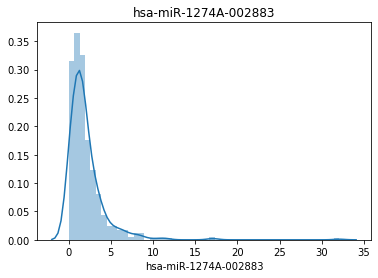

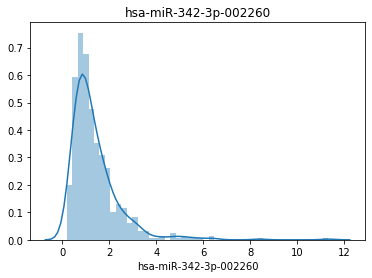

In [2]:
#Let's plot two random columns to see the distribution
plt.clf()
sns.distplot(train['hsa-miR-1274A-002883'])
plt.title('hsa-miR-1274A-002883')
plt.show()

plt.clf()
sns.distplot(train['hsa-miR-342-3p-002260'])
plt.title('hsa-miR-342-3p-002260')
plt.show()

#Here we confirm that the miRNAs follow the "normal" negative binomial distribution for gene expression data 

In [32]:
#Let's see again how many missing data there are / column
train.isna().sum()

inc_dm_2009                 0
inc_cv_2009                 0
hsa-miR-1274A-002883        0
hsa-miR-17-002308           0
hsa-miR-1243-002854       247
hsa-miR-1274B-002884        1
hsa-miR-625*-002432        47
hsa-miR-223-002295          0
hsa-miR-126-002228          0
hsa-miR-484-001821          0
hsa-miR-320-002277          0
hsa-miR-191-002299          0
hsa-miR-106a-002169         0
hsa-let-7b-002619          10
mmu-miR-451-001141         30
hsa-miR-342-3p-002260       0
hsa-miR-338-5P-002658       0
hsa-let-7e-002406           3
hsa-miR-486-001278          0
hsa-miR-28-3p-002446      189
hsa-miR-222-002276          1
hsa-miR-483-5p-002338       0
hsa-miR-122-002245        143
hsa-miR-146b-001097         8
hsa-miR-20b-001014         39
hsa-miR-574-3p-002349       0
hsa-miR-186-002285         38
hsa-miR-145-002278         69
hsa-miR-125a-5p-002198    371
hsa-let-7d-002283          87
hsa-miR-146a-000468         0
hsa-miR-92a-000431          1
hsa-miR-24-000402           1
hsa-miR-15

In [3]:
#As we see we have 7 individuals with no prediction over if they are going to develop dm or cm ("inc_dm_2009", "inc_cv_2009"), 
#so we need to remove them from the downstream analysis 

train = train.dropna(how='any', subset=['inc_dm_2009', 'inc_cv_2009'])

#we are also going to remove sample ids labels
train = train.drop('CardID', 1)

train.shape

(553, 49)

In [4]:
#Our feature varuables (all numerical) start from the 3rd column
X = train.iloc[:,3:]

#Our target variable is the "inc_dm_2009" or "inc_cv_2009" column
y = train['inc_dm_2009']
#we can convert it to integer 
y = y.astype(int)


In [5]:
#Before any pre-processing we should split the data!

#Now split the data into training and testing before pre-processing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(X_train.shape)
#print(X_test.shape)




#Maybe later trying to scale down the healthy subset to the levels of the two 

In [7]:
y_test

88     0
136    0
99     1
110    0
144    1
      ..
206    1
192    1
79     0
212    1
323    0
Name: inc_dm_2009, Length: 111, dtype: int64

In [ ]:
#A large amount of the total data is missing in some cases, with columns missing even 80% of the data ("hsa-miR-25-000403").

#The chosen imputation methods did not work well with data that follow the negative bionomial distribution so as to impute and
#log-transform and scale later --- so I will log normalise first, impute and then scale



In [10]:
#Let's log-transform miRNA values to follow the normal distribution
X_log = np.log2(X)

X_train_log = np.log2(X_train)

X_test_log = np.log2(X_test)

In [28]:
#Imputation - It was found that for microarray missing values the weighted nearest neighbors imputation (knn imputation) 
#is a popular method - we will use it in columns missing 10% of the feature values - rest of the columns will be removed

#remove columns with missing data > 10% in the whole dataset and then impute test and train sets:
cols = X_log.columns[X_log.isnull().mean() < 0.1]

#set sets with those columns
X_train_log_flt = X_train_log[cols]
X_test_log_flt = X_test_log[cols]

#13/49 features were removed

#imputation - I will fit and transform the train set and then fit to the test set in order to simulate real testing conditions
from sklearn.impute import KNNImputer
    
imputer = KNNImputer(n_neighbors=2, weights="uniform")

X_train_imp = imputer.fit_transform(X_train_log)
X_test_imp = imputer.transform(X_test_log) #Here we only need to transform the test data

In [30]:
#Now we will scale the data to [0,1] as it is necessary for some distance-based machine learning estimators (SVM, knn) 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc = scaler.transform(X_test_imp) #Here we only need to transform the test data

In [54]:
#SVM model

#svm is independent of the dimensionality of the feature space as the appriate selection of the regularisation parameter C 
#can prevent overfitting - so feature selection is not going to be applied here

#We will do a grid search with 3 types of kernels (linear, rbf, polynomial)
from time import process_time
from sklearn.model_selection import GridSearchCV
from sklearn import svm

t0= process_time()

parameters = [{'kernel':['linear'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000]}, 
              {'kernel':['rbf'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000]},
             {'kernel':['poly'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000],
             'degree': [1, 2, 3, 4, 5]}]

svc = svm.SVC()
svm_model = GridSearchCV(svc, parameters, cv = 5) #(Stratified)KFold is used as cross-validation strategy as 
                                                  #our target feature is binary
svm_model.fit(X_train_sc, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

t1 = process_time() - t0
print("Time elapsed: ", t1)


KeyboardInterrupt: 

In [20]:
#Try grid search with cleaner code
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
grid.fit(X_train_sc, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.01, 'gamma': 1e-09} with a score of 0.72


In [65]:
#Decision Trees

#Decision trees tend to overfit on data with a large number of features so first we will perform dimensionality reduction
#using pca

#The rationale is to take advantage of the Pipeline function of sklearn in order to grid search for the best number of PCA 
#components to input in our decision trees, and the best hyperparameters of our tree at the same time 

from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier()

# Create a pipeline of two steps: 
# 1) tranform the data with PCA, 2) train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('decisiontree', decisiontree)])

# Create Parameter Space

# Create a list of a sequence of integers to integrate from PCA
n_components = list(range(1,X_train_sc.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

clf = GridSearchCV(pipe, parameters, cv = 5)

clf.fit(X_train_sc, y_train)

print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(clf.best_estimator_.get_params()['decisiontree'])
    
    

KeyboardInterrupt: 

In [66]:
parameters

{'pca__n_components': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 'decisiontree__criterion': ['gini', 'entropy'],
 'decisiontree__max_depth': [4, 6, 8, 12]}

In [61]:
n_components = list(range(1,X_train_sc.shape[1]+1,1))
n_components

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [ ]:
#We will try:
#SVM
#General discriminant analysis
#Decision Trees
#Random Forest
#GLMs (generalized linear models) -- logistic regression tried in paper

#do feature selection 


In [ ]:
#feature selection before SVM (PCA?)

In [ ]:
#first log values, then scale -1,1 or 0,1 ## one hot encoding for the categorical variables 